In [1]:
"""
Yolo V1 by tensorflow
"""

import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def leak_relu(x, alpha=0.1):
    return tf.maximum(alpha * x, x)

In [3]:
class Yolo(object):
    def __init__(self, weights_file, verbose=True):
        self.verbose = verbose
        # detection params
        self.S = 7  # cell size
        self.B = 2  # boxes_per_cell
        self.classes = ["aeroplane", "bicycle", "bird", "boat", "bottle",
                        "bus", "car", "cat", "chair", "cow", "diningtable",
                        "dog", "horse", "motorbike", "person", "pottedplant",
                        "sheep", "sofa", "train","tvmonitor"]
        self.C = len(self.classes) # number of classes
        # offset for box center (top left point of each cell)
        self.x_offset = np.transpose(np.reshape(np.array([np.arange(self.S)]*self.S*self.B),
                                              [self.B, self.S, self.S]), [1, 2, 0])
        self.y_offset = np.transpose(self.x_offset, [1, 0, 2])

        self.threshold = 0.2  # confidence scores threhold
        self.iou_threshold = 0.4
        #  the maximum number of boxes to be selected by non max suppression
        self.max_output_size = 10

        self.sess = tf.Session()
        self._build_net()
        self._build_detector()
        self._load_weights(weights_file)

    def _build_net(self):
        """build the network"""
        if self.verbose:
            print("Start to build the network ...")
        self.images = tf.placeholder(tf.float32, [None, 448, 448, 3])
        net = self._conv_layer(self.images, 1, 64, 7, 2)
        net = self._maxpool_layer(net, 1, 2, 2)
        net = self._conv_layer(net, 2, 192, 3, 1)
        net = self._maxpool_layer(net, 2, 2, 2)
        net = self._conv_layer(net, 3, 128, 1, 1)
        net = self._conv_layer(net, 4, 256, 3, 1)
        net = self._conv_layer(net, 5, 256, 1, 1)
        net = self._conv_layer(net, 6, 512, 3, 1)
        net = self._maxpool_layer(net, 6, 2, 2)
        net = self._conv_layer(net, 7, 256, 1, 1)
        net = self._conv_layer(net, 8, 512, 3, 1)
        net = self._conv_layer(net, 9, 256, 1, 1)
        net = self._conv_layer(net, 10, 512, 3, 1)
        net = self._conv_layer(net, 11, 256, 1, 1)
        net = self._conv_layer(net, 12, 512, 3, 1)
        net = self._conv_layer(net, 13, 256, 1, 1)
        net = self._conv_layer(net, 14, 512, 3, 1)
        net = self._conv_layer(net, 15, 512, 1, 1)
        net = self._conv_layer(net, 16, 1024, 3, 1)
        net = self._maxpool_layer(net, 16, 2, 2)
        net = self._conv_layer(net, 17, 512, 1, 1)
        net = self._conv_layer(net, 18, 1024, 3, 1)
        net = self._conv_layer(net, 19, 512, 1, 1)
        net = self._conv_layer(net, 20, 1024, 3, 1)
        net = self._conv_layer(net, 21, 1024, 3, 1)
        net = self._conv_layer(net, 22, 1024, 3, 2)
        net = self._conv_layer(net, 23, 1024, 3, 1)
        net = self._conv_layer(net, 24, 1024, 3, 1)
        net = self._flatten(net)
        net = self._fc_layer(net, 25, 512, activation=leak_relu)
        net = self._fc_layer(net, 26, 4096, activation=leak_relu)
        net = self._fc_layer(net, 27, self.S*self.S*(self.C+5*self.B))
        self.predicts = net

    def _build_detector(self):
        """Interpret the net output and get the predicted boxes"""
        # the width and height of orignal image
        self.width = tf.placeholder(tf.float32, name="img_w")
        self.height = tf.placeholder(tf.float32, name="img_h")
        # get class prob, confidence, boxes from net output
        idx1 = self.S * self.S * self.C
        idx2 = idx1 + self.S * self.S * self.B
        # class prediction
        class_probs = tf.reshape(self.predicts[0, :idx1], [self.S, self.S, self.C])
        # confidence
        confs = tf.reshape(self.predicts[0, idx1:idx2], [self.S, self.S, self.B])
        # boxes -> (x, y, w, h)
        boxes = tf.reshape(self.predicts[0, idx2:], [self.S, self.S, self.B, 4])

        # convert the x, y to the coordinates relative to the top left point of the image
        # the predictions of w, h are the square root
        # multiply the width and height of image
        boxes = tf.stack([(boxes[:, :, :, 0] + tf.constant(self.x_offset, dtype=tf.float32)) / self.S * self.width,
                          (boxes[:, :, :, 1] + tf.constant(self.y_offset, dtype=tf.float32)) / self.S * self.height,
                          tf.square(boxes[:, :, :, 2]) * self.width,
                          tf.square(boxes[:, :, :, 3]) * self.height], axis=3)

        # class-specific confidence scores [S, S, B, C]
        scores = tf.expand_dims(confs, -1) * tf.expand_dims(class_probs, 2)

        scores = tf.reshape(scores, [-1, self.C])  # [S*S*B, C]
        boxes = tf.reshape(boxes, [-1, 4])  # [S*S*B, 4]

        # find each box class, only select the max score
        box_classes = tf.argmax(scores, axis=1)
        box_class_scores = tf.reduce_max(scores, axis=1)

        # filter the boxes by the score threshold
        filter_mask = box_class_scores >= self.threshold
        scores = tf.boolean_mask(box_class_scores, filter_mask)
        boxes = tf.boolean_mask(boxes, filter_mask)
        box_classes = tf.boolean_mask(box_classes, filter_mask)

        # non max suppression (do not distinguish different classes)
        # ref: https://tensorflow.google.cn/api_docs/python/tf/image/non_max_suppression
        # box (x, y, w, h) -> box (x1, y1, x2, y2)
        _boxes = tf.stack([boxes[:, 0] - 0.5 * boxes[:, 2], boxes[:, 1] - 0.5 * boxes[:, 3],
                           boxes[:, 0] + 0.5 * boxes[:, 2], boxes[:, 1] + 0.5 * boxes[:, 3]], axis=1)
        nms_indices = tf.image.non_max_suppression(_boxes, scores,
                                                   self.max_output_size, self.iou_threshold)
        self.scores = tf.gather(scores, nms_indices)
        self.boxes = tf.gather(boxes, nms_indices)
        self.box_classes = tf.gather(box_classes, nms_indices)

    def _conv_layer(self, x, id, num_filters, filter_size, stride):
        """Conv layer"""
        in_channels = x.get_shape().as_list()[-1]
        weight = tf.Variable(tf.truncated_normal([filter_size, filter_size,
                                                  in_channels, num_filters], stddev=0.1))
        bias = tf.Variable(tf.zeros([num_filters,]))
        # padding, note: not using padding="SAME"
        pad_size = filter_size // 2
        pad_mat = np.array([[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]])
        x_pad = tf.pad(x, pad_mat)
        conv = tf.nn.conv2d(x_pad, weight, strides=[1, stride, stride, 1], padding="VALID")
        output = leak_relu(tf.nn.bias_add(conv, bias))
        if self.verbose:
            print("    Layer %d: type=Conv, num_filter=%d, filter_size=%d, stride=%d, output_shape=%s" \
                  % (id, num_filters, filter_size, stride, str(output.get_shape())))
        return output

    def _fc_layer(self, x, id, num_out, activation=None):
        """fully connected layer"""
        num_in = x.get_shape().as_list()[-1]
        weight = tf.Variable(tf.truncated_normal([num_in, num_out], stddev=0.1))
        bias = tf.Variable(tf.zeros([num_out,]))
        output = tf.nn.xw_plus_b(x, weight, bias)
        if activation:
            output = activation(output)
        if self.verbose:
            print("    Layer %d: type=Fc, num_out=%d, output_shape=%s" \
                  % (id, num_out, str(output.get_shape())))
        return output

    def _maxpool_layer(self, x, id, pool_size, stride):
        output = tf.nn.max_pool(x, [1, pool_size, pool_size, 1],
                                strides=[1, stride, stride, 1], padding="SAME")
        if self.verbose:
            print("    Layer %d: type=MaxPool, pool_size=%d, stride=%d, output_shape=%s" \
                  % (id, pool_size, stride, str(output.get_shape())))
        return output

    def _flatten(self, x):
        """flatten the x"""
        tran_x = tf.transpose(x, [0, 3, 1, 2])  # channle first mode
        nums = np.product(x.get_shape().as_list()[1:])
        return tf.reshape(tran_x, [-1, nums])

    def _load_weights(self, weights_file):
        """Load weights from file"""
        if self.verbose:
            print("Start to load weights from file:%s" % (weights_file))
        saver = tf.train.Saver()
        saver.restore(self.sess, weights_file)

    def detect_from_file(self, image_file, imshow=True, deteted_boxes_file="boxes.txt",
                     detected_image_file="detected_image.jpg"):
        """Do detection given a image file"""
        # read image
        image = cv2.imread(image_file)
        img_h, img_w, _ = image.shape
        scores, boxes, box_classes = self._detect_from_image(image)
        predict_boxes = []
        for i in range(len(scores)):
            predict_boxes.append((self.classes[box_classes[i]], boxes[i, 0],
                                boxes[i, 1], boxes[i, 2], boxes[i, 3], scores[i]))
        self.show_results(image, predict_boxes, imshow, deteted_boxes_file, detected_image_file)

    def _detect_from_image(self, image):
        """Do detection given a cv image"""
        img_h, img_w, _ = image.shape
        img_resized = cv2.resize(image, (448, 448))
        img_RGB = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        img_resized_np = np.asarray(img_RGB)
        _images = np.zeros((1, 448, 448, 3), dtype=np.float32)
        _images[0] = (img_resized_np / 255.0) * 2.0 - 1.0
        scores, boxes, box_classes = self.sess.run([self.scores, self.boxes, self.box_classes],
                    feed_dict={self.images: _images, self.width: img_w, self.height: img_h})
        return scores, boxes, box_classes

    def show_results(self, image, results, imshow=True, deteted_boxes_file=None,
                     detected_image_file=None):
        """Show the detection boxes"""
        img_cp = image.copy()
        if deteted_boxes_file:
            f = open(deteted_boxes_file, "w")
        #  draw boxes
        for i in range(len(results)):
            x = int(results[i][1])
            y = int(results[i][2])
            w = int(results[i][3]) // 2
            h = int(results[i][4]) // 2
            if self.verbose:
                print("   class: %s, [x, y, w, h]=[%d, %d, %d, %d], confidence=%f" % (results[i][0],
                            x, y, w, h, results[i][-1]))

                cv2.rectangle(img_cp, (x - w, y - h), (x + w, y + h), (0, 255, 0), 2)
                cv2.rectangle(img_cp, (x - w, y - h - 20), (x + w, y - h), (125, 125, 125), -1)
                cv2.putText(img_cp, results[i][0] + ' : %.2f' % results[i][5], (x - w + 5, y - h - 7),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
            if deteted_boxes_file:
                f.write(results[i][0] + ',' + str(x) + ',' + str(y) + ',' +
                        str(w) + ',' + str(h)+',' + str(results[i][5]) + '\n')
        if imshow:
            cv2.imshow('YOLO_small detection', img_cp)
            cv2.waitKey(1)
        if detected_image_file:
            cv2.imwrite(detected_image_file, img_cp)
        if deteted_boxes_file:
            f.close()

In [4]:
if __name__ == "__main__":
    yolo_net = Yolo("./YOLO_small.ckpt")
    yolo_net.detect_from_file("./test_images/cat.jpg")

Start to build the network ...
    Layer 1: type=Conv, num_filter=64, filter_size=7, stride=2, output_shape=(?, 224, 224, 64)
    Layer 1: type=MaxPool, pool_size=2, stride=2, output_shape=(?, 112, 112, 64)
    Layer 2: type=Conv, num_filter=192, filter_size=3, stride=1, output_shape=(?, 112, 112, 192)
    Layer 2: type=MaxPool, pool_size=2, stride=2, output_shape=(?, 56, 56, 192)
    Layer 3: type=Conv, num_filter=128, filter_size=1, stride=1, output_shape=(?, 56, 56, 128)
    Layer 4: type=Conv, num_filter=256, filter_size=3, stride=1, output_shape=(?, 56, 56, 256)
    Layer 5: type=Conv, num_filter=256, filter_size=1, stride=1, output_shape=(?, 56, 56, 256)
    Layer 6: type=Conv, num_filter=512, filter_size=3, stride=1, output_shape=(?, 56, 56, 512)
    Layer 6: type=MaxPool, pool_size=2, stride=2, output_shape=(?, 28, 28, 512)
    Layer 7: type=Conv, num_filter=256, filter_size=1, stride=1, output_shape=(?, 28, 28, 256)
    Layer 8: type=Conv, num_filter=512, filter_size=3, stride

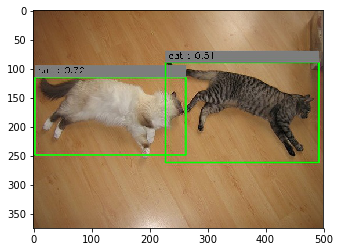

In [5]:
result_img = Image.open('./detected_image.jpg')
plt.imshow(result_img)
plt.show()